# Titanic ML Challenge

## Exploratory Data Analysis (lightweight)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv", index_col = "PassengerId")
train_df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Checking for NaNs
train_df.isna().sum()

# There are 177 Missing values on Age, 687 missing values for cabin, 2 missing values on embarked

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
# Evaluating balancing among targets
train_df["Survived"].value_counts()

# Dataset is slightly umbalanced

Survived
0    549
1    342
Name: count, dtype: int64

<Axes: >

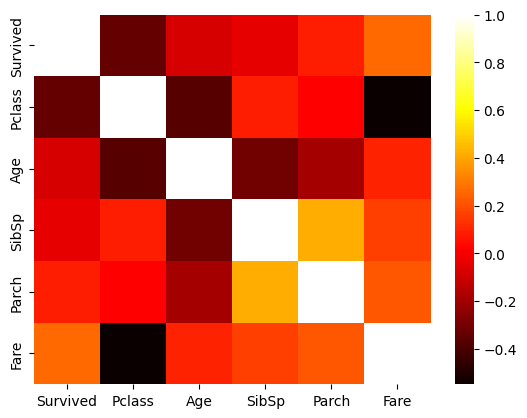

In [6]:
# Linear Correlation Matrix
not_categorical_df = train_df.drop(["Name", "Sex", "Cabin", "Embarked", "Ticket"], axis=1)
sns.heatmap(not_categorical_df.corr(), cmap="hot")


### Cabin and Classes

One possible predictor for chance of surviving could be the appartenence to one or another ticket class or, alternatively, the possession of a Cabin among the tickets. In particular, even if it not completely correct, whoever has data related to cabin has a registered cabin while NaNs values mean that that particular person had not booked a cabin.

Being part of a class may be an indicator of the location that person could be during the disaster.

In [7]:
print("% of passengers in First class without cabin", train_df[train_df["Pclass"] == 1]["Cabin"].isna().sum() / len(train_df[train_df["Pclass"] == 1])*100)
print("% of passengers in Second class without cabin", train_df[train_df["Pclass"] == 2]["Cabin"].isna().sum() / len(train_df[train_df["Pclass"] == 2])*100)
print("% of passengers in Third class without cabin", train_df[train_df["Pclass"] == 3]["Cabin"].isna().sum() / len(train_df[train_df["Pclass"] == 3])*100)

% of passengers in First class without cabin 18.51851851851852
% of passengers in Second class without cabin 91.30434782608695
% of passengers in Third class without cabin 97.5560081466395


In [8]:

print("% of passengers in First class that survived", len(train_df[(train_df["Survived"] == 1) & (train_df["Pclass"] == 1)]) / len(train_df[train_df["Pclass"] == 1])*100)
print("% of passengers in Second class that survived", len(train_df[(train_df["Survived"] == 1) & (train_df["Pclass"] == 2)]) / len(train_df[train_df["Pclass"] == 2])*100)
print("% of passengers in Third class that survived", len(train_df[(train_df["Survived"] == 1) & (train_df["Pclass"] == 3)]) / len(train_df[train_df["Pclass"] == 3])*100)



% of passengers in First class that survived 62.96296296296296
% of passengers in Second class that survived 47.28260869565217
% of passengers in Third class that survived 24.236252545824847


### Conclusion
Input variables seem not linearly correlated with other input variables, neither with output variables. The only exception is PClass vs Fare which are negatively correlated (obviously lower classes relate with higher prices).

Sex Variable will be transformed to be a 1/0 class. Embarking location was ignored since it intuitively is not a predictor for survival rate. In further tests it could be added

Age is a variable containing NaNs, however it seems uncorrelated. Different methods will be tested to cover this problem, starting by substituting the median age

It will be added a dummy variable "HasCabin" to check if a passenger has a cabin. It could be interesting to understand if passengers on cabin were more or less subject to survive. 

Moreover, an additional variable based on "cabin zone": CabinLevel is created, based on the letter of the Deck on which are situated, such as expressed in: https://en.wikipedia.org/wiki/Titanic#Dimensions_and_layout. 

About Target variable, there is some asymmetry between unsurvived and survived passengers, however dataset is not totally umbalanced.

## Preprocessing Functions


In [9]:
def add_cabin_level(df):
    # Checks for cabin letter and assign value based on area (cabin letter).
    # If cabin is NaN, assign 0, otherwise assign A=1, B=2 and so on
    
    array_level_name = np.zeros(len(df))
    for idx, val in enumerate(df["Cabin"].values):
        if val is not np.nan:
            array_level_name[idx] = ord(val[0]) - ord("A") +1

    df["CabinLevel"] = array_level_name
    return df



def add_has_cabin(df):
    # Sets 1 to any passenger with one or more cabins, 0 otherwise
    
    df["HasCabin"] = df["Cabin"].isna().astype("int")
    return df



def adjust_sex(df):
    # Assigns 1 to male sex, 0 otherwise
    
    df["Sex"] = pd.get_dummies(df, columns=["Sex"])["Sex_male"].astype(int)
    return df


def fill_age_median(df):
    # Fill missing age values with median
    
    df["Age"] = df["Age"].fillna(value=df["Age"].median())
    return df


def balance_dataset(df, target_col):
    
    zeros = df[df[target_col] == 0]
    ones = df[df[target_col] == 1]
    print("Old Lenght of dataframe:", len(df))
    
    max_choice = np.argmax([len(zeros), len(ones)])
    minimum = min(len(zeros), len(ones))
    maximum = max(len(zeros), len(ones))
    diff = maximum-minimum
    
    indexes_to_drop = np.random.choice(df[df[target_col] == max_choice].index, size=diff, replace=False)
    new_df = df.drop(indexes_to_drop, axis=0)
    dropped_df = df.loc[indexes_to_drop]
    print("New Lenght of dataframe:", len(new_df))
    print("New Lenght of dropped dataframe:", len(dropped_df))
    return new_df, dropped_df


def filter_df(df, columns):
    # Return df with relevant columns
    
    return df[columns].copy()



def train_test_split(df, frac=0.8):
    # Train test split. Change frac only to train dataset for model validation.
    
    train = df.sample(frac=frac, random_state=1)
    test = df.drop(train.index)
    
    return train, test


def x_y_split(df):
    x = df.drop("Survived", axis=1)
    y = df["Survived"]
    
    return x, y


def setup_pipeline():
    columns = ["Sex", "Pclass", "Age", "CabinLevel", "Parch", "SibSp"]
    categorical_columns = ["Sex", "Pclass", "CabinLevel"]
    return columns, categorical_columns


    

def preprocessing_pipeline(df_input, columns, train=True):
    
    df = df_input.copy()
    
    
    if train:
        columns.append("Survived")
    df = adjust_sex(df)
    df = add_has_cabin(df)
    df = add_cabin_level(df)
    df = fill_age_median(df)
    filtered_df = filter_df(df, columns)
    
    return filtered_df

    

def train_test_preprocessing_pipeline(df_input, balance=False):
    
    df = df_input.copy()
    columns, categorical_columns = setup_pipeline()
    
    filtered_df = preprocessing_pipeline(df, columns, train=True)
    
    if balance:
        filtered_df, dropped_df = balance_dataset(filtered_df, target_col="Survived")
    
    train, test = train_test_split(filtered_df, frac=0.7)
    
    if balance:
        # Agument Balance with dropped df
        test = pd.concat([test, dropped_df])
    
    x_train, y_train = x_y_split(train)
    x_val, y_val = x_y_split(test)
    
    return filtered_df, x_train, y_train, x_val, y_val



def test_preprocessing_pipeline(df_input, OH_encoder=None):
    
    df = df_input.copy()
    columns, categorical_columns = setup_pipeline()
    
    filtered_df = preprocessing_pipeline(df, columns, train=False)
    
   
    
    return filtered_df

## Inference and Utility Functions


In [10]:
def prettyprint_classification_report(report):
        
    report_mean = report["macro avg"]
    print(f'Accuracy obtained: {report["accuracy"]}')
    print(f'Macro Average precision: {report_mean["precision"]}')
    print(f'Macro Average recall: {report_mean["recall"]}')
    print(f'Macro Average f1 score: {report_mean["f1-score"]}')
    
    
def prettyprint_confusion_matrix(matrix):
    # Careful: Here class 0 means Unsurvived. Test negativity is meant to be "unsurvived"
    # Sklearn has predicted on columns and Actual on rows
    
    tn = matrix[0,0]
    tp = matrix[1,1]
    fp = matrix[0,1]
    fn = matrix[1,0]
    
    print("True Unsurvived (TN): ", tn)
    print("True  Survived (TP): ", tp)
    print("Predicted Survived but actually Not Alive (FP): ", fp)
    print("Predicted Unsurvived but actually Alive (FN): ", fn)
    print("---Report:---")
    precision = tp/(tp+fp)
    recall= tp/(tp+fn)
    tnr = tn/(tn+fp)
    print("Computed Precision (True survived over all predicted Survived): ", precision)
    print("Computed Recall: (True survived over all actual Survived)", recall )
    print("Computed True Negative Rate: (True Unsurvived over all actual Unsurvived)", tnr )
    print("Computed Balanced Accuracy: ", (recall+tnr)/2 )
    print("Computed F1 Score: ", 2*(precision*recall)/(precision+recall))
    
    
def prediction_threshold_report(predictions_probability, threshold):
    
    test_prediction_max = np.maximum(predictions_probability[:,0], predictions_probability[:,1])
    prediction_over_threshold = test_prediction_max[test_prediction_max>=threshold]
    prediction_under_threshold = test_prediction_max[test_prediction_max<threshold]
    confident_prediction_ratio = len(prediction_over_threshold)/len(test_prediction_max)
    
    
    plt.hist(test_prediction_max, bins=50)
    plt.title("Distribution of prediction probability")
    plt.xlabel("Probability")
    plt.ylabel("Samples")
    plt.axvline(threshold, c="r", label="Confidence Threshold")
    plt.title(f"Prediction: confidence over threshold ratio: {confident_prediction_ratio}")
    plt.legend()
    
    

def plot_roc_curve(y_test, predictions):
    fpr, tpr, _ = roc_curve(y_test,  predictions)
    auc = roc_auc_score(y_test,  predictions)

    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f"ROC with AUC:{auc}")
    plt.show()
    
    

def plot_probability_guessing_hists(y_test, predictions, predictions_probabilities):
    
    fig, ax = plt.subplots()
    
    guessed = (y_test == predictions).astype("int")
    df_test = pd.DataFrame(data=np.c_[predictions_probabilities, guessed], columns=["PredictionProbability", "Guess"])
    df_ok = df_test[df_test.Guess==1]
    df_ok["PredictionProbability"].hist(density=False, ax=ax, label="Guessed", alpha=0.5, bins=20)
    df_not_ok = df_test[df_test.Guess==0]
    df_not_ok["PredictionProbability"].hist(density=False, ax=ax, label="Not Guessed", alpha=0.5, bins=20)
    ax.set_xlabel("Prediction Probability")
    ax.set_ylabel("Density of Guessings")
    ax.set_title("Histogram of Guessings")
    ax.legend()

## PreProcessing

The preprocessing pipeline transform the dataset to cover some critical aspects such as missing age values, filtering unused features and adding additional features.

- About missing values, age will be replaced by median value
- The CabinLevel variable is created to substitute Cabin feature, using the function "add_cabin_level" assigning an integer based on the first letter of the cabin, which is more related to the dock area.
- Due to correlation between Fare, PClass and possession of a Cabin, Fare variable is excluded from input features
- Ticket, Embarked, Name variables were deleted

### Training Set

Preprocessing steps are applied to training set. Furthermore, it was splitted into train and validation set while separating input features from targets

In [11]:
new_df, x_train, y_train, x_test, y_test = train_test_preprocessing_pipeline(train_df, balance=False)
new_df.head()

,Sex,Pclass,Age,CabinLevel,Parch,SibSp,Survived
PassengerId,,,,,,,
1,1,3,22.0,0.0,0,1,0
2,0,1,38.0,3.0,0,1,1
3,0,3,26.0,0.0,0,0,1
4,0,1,35.0,3.0,0,1,1
5,1,3,35.0,0.0,0,0,0


### Kaggle Test Set

On Test set, only preprocessing steps are performed

In [12]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv", index_col = "PassengerId")
filtered_test = test_preprocessing_pipeline(test_df)
filtered_test.head()

,Sex,Pclass,Age,CabinLevel,Parch,SibSp
PassengerId,,,,,,
892,1,3,34.5,0.0,0,0
893,0,3,47.0,0.0,0,1
894,1,2,62.0,0.0,0,0
895,1,3,27.0,0.0,0,0
896,0,3,22.0,0.0,1,1


## Random Forest Test

A first test is trying to use data that has info about cabins and levels. For example it could be useful to check if "having a cabin" is a nice predictor of our algorithm.

### Training

Not so much effort. A random forest classifier kept with default parameters and using 100 estimators

In [13]:
rf = RandomForestClassifier(n_estimators=100)

In [14]:
rf.fit(x_train, y_train)

RandomForestClassifier()

### Validation

Validation of fit classifier using a part of the training set

In [15]:
predictions = rf.predict(x_test)
predictions_proba = rf.predict_proba(x_test)

In [16]:
report = classification_report(y_test.values, predictions, output_dict=True)
prettyprint_classification_report(report)

Accuracy obtained: 0.846441947565543
Macro Average precision: 0.8277972027972028
Macro Average recall: 0.8295668549905838
Macro Average f1 score: 0.8286666771007779


In [17]:
prettyprint_confusion_matrix(confusion_matrix(y_test.values, predictions))

True Unsurvived (TN):  156
True  Survived (TP):  70
Predicted Survived but actually Not Alive (FP):  21
Predicted Unsurvived but actually Alive (FN):  20
---Report:---
Computed Precision (True survived over all predicted Survived):  0.7692307692307693
Computed Recall: (True survived over all actual Survived) 0.7777777777777778
Computed True Negative Rate: (True Unsurvived over all actual Unsurvived) 0.8813559322033898
Computed Balanced Accuracy:  0.8295668549905838
Computed F1 Score:  0.7734806629834255


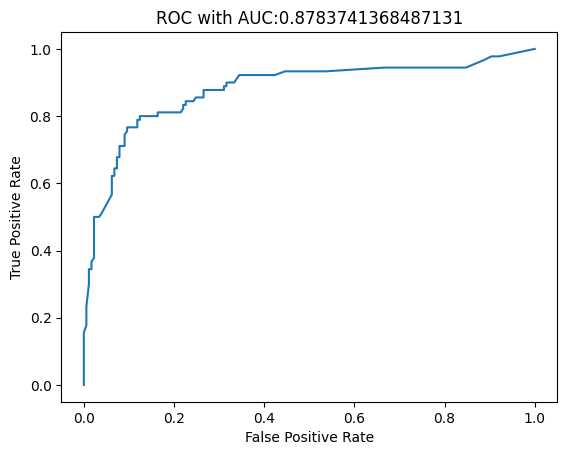

In [18]:
plot_roc_curve(y_test.values, predictions_proba[:,1])

### Validation against some baseline models

#### "None Survived" Classifier

In [19]:
dummy_predictions_1 = np.zeros(y_test.shape[0])
dummy_predictions_1.shape
dummy_report = classification_report(y_test.values, dummy_predictions_1, output_dict=True, zero_division=True)
prettyprint_classification_report(dummy_report)

Accuracy obtained: 0.6629213483146067
Macro Average precision: 0.8314606741573034
Macro Average recall: 0.5
Macro Average f1 score: 0.39864864864864863


#### Only Woman Survived Classifier

In [20]:
dummy_predictions_sex_female = np.abs(x_test["Sex"].values.astype("int16") -1)
report_sex_female = classification_report(y_test.values, dummy_predictions_sex_female, output_dict=True)
prettyprint_classification_report(report_sex_female)

Accuracy obtained: 0.797752808988764
Macro Average precision: 0.774060436769934
Macro Average recall: 0.7709981167608286
Macro Average f1 score: 0.7724719101123596


### Explainable AI with Lime

In [21]:
import lime.lime_tabular
from lime.submodular_pick import SubmodularPick

In [22]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x_train.columns, class_names=[0, 1],  discretize_continuous=True)


In [23]:
%%capture
# Random Sample 
i = np.random.randint(0, x_test.shape[0])
exp = explainer.explain_instance(x_test.iloc[i], rf.predict_proba, num_features=5, top_labels=1)


In [24]:
print(rf.predict_proba(x_test)[i], rf.predict(x_test)[i], y_test.iloc[i])
exp.show_in_notebook(show_table=True, show_all=True)

[0.055 0.945] 1 1


In [25]:
%%capture

# Submodular pick to understand model
sp_obj = SubmodularPick(explainer, x_train.values, rf.predict_proba, sample_size=100, num_features=len(x_train.columns), num_exps_desired=2)

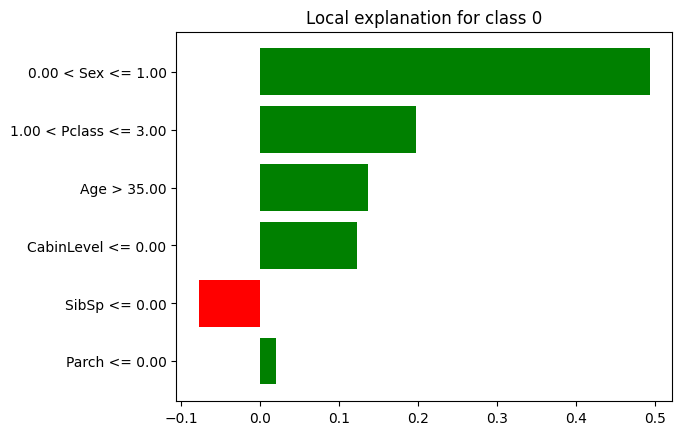

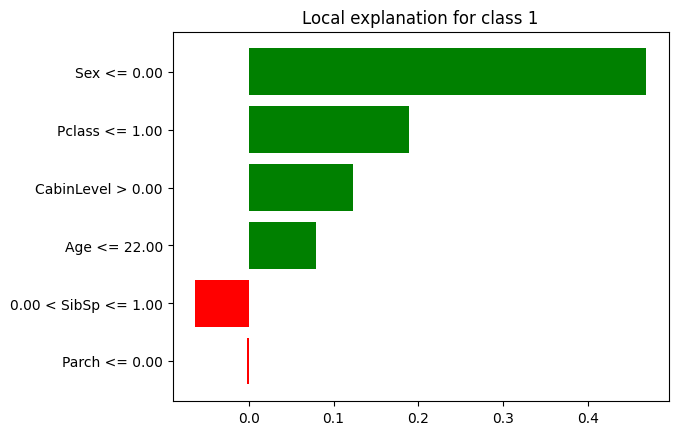

In [26]:
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

#### Explainable AI insights:

- For class "Not survived":

    - Sex = 1 (Male) is high indicator of not surviving
    - Age > 34 is moderate indicator of not surviving
    - Cabin lvl = 0 (has no cabin) is indicator of not surviving
    - Third class passengers were more likely of not surviving
    - NOT Having a sibling/spouse NEGATIVELY influence probability of death

- For class "Survived":

    - Sex = 0 (Female) is high indicator of surviving
    - First Class or Second Class passengers were more likely to survive
    - Passengers with cabins were unespectedly more likely to survive (coincides with higher class passgs)
    - Having sibling or spouse negatively influences survivability (again)
    - Age <= 22 is indicator of survivability


From this analysis, it seems that richier people, women and jounger people were more likely to survive

### On Kaggle Test Set 



In [27]:
test_predictions = rf.predict(filtered_test)

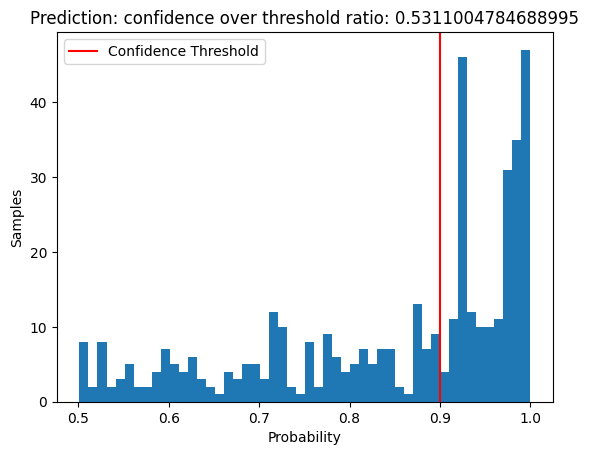

In [28]:
test_predictions_proba = rf.predict_proba(filtered_test)
prediction_threshold_report(test_predictions_proba, 0.9)

## XGBoost Test

In [29]:
import xgboost as xgb

In [30]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=2)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=2, ...)

In [31]:
xgb_prediction = xgb_model.predict(x_test)

In [32]:
report = classification_report(y_test.values, xgb_prediction, output_dict=True)
prettyprint_classification_report(report)

Accuracy obtained: 0.850187265917603
Macro Average precision: 0.8333862366683595
Macro Average recall: 0.8296610169491525
Macro Average f1 score: 0.8314606741573034


In [33]:
prettyprint_confusion_matrix(confusion_matrix(y_test.values, xgb_prediction))

True Unsurvived (TN):  158
True  Survived (TP):  69
Predicted Survived but actually Not Alive (FP):  19
Predicted Unsurvived but actually Alive (FN):  21
---Report:---
Computed Precision (True survived over all predicted Survived):  0.7840909090909091
Computed Recall: (True survived over all actual Survived) 0.7666666666666667
Computed True Negative Rate: (True Unsurvived over all actual Unsurvived) 0.8926553672316384
Computed Balanced Accuracy:  0.8296610169491525
Computed F1 Score:  0.7752808988764045


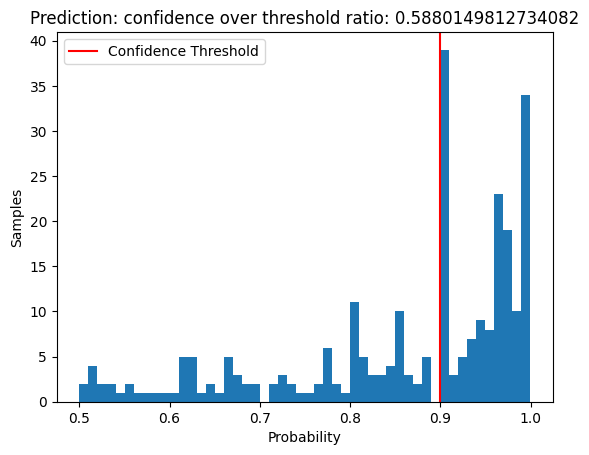

In [34]:
xgb_prediction_proba = xgb_model.predict_proba(x_test)
prediction_threshold_report(xgb_prediction_proba, 0.9)

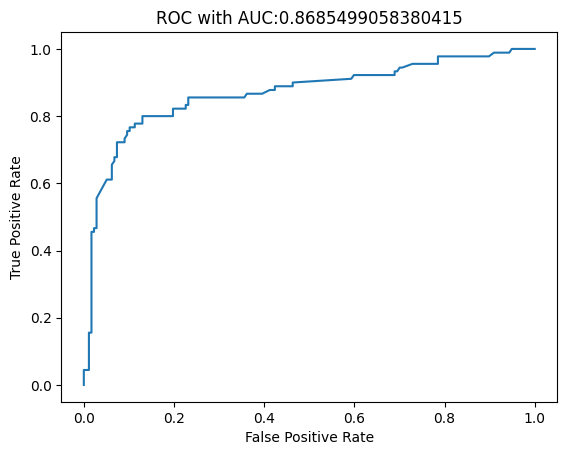

In [35]:
plot_roc_curve(y_test.values, xgb_prediction_proba[:,1])

### On Kaggle Test Set

Only ~52.15% of predictions were predicted using over 90% of probability

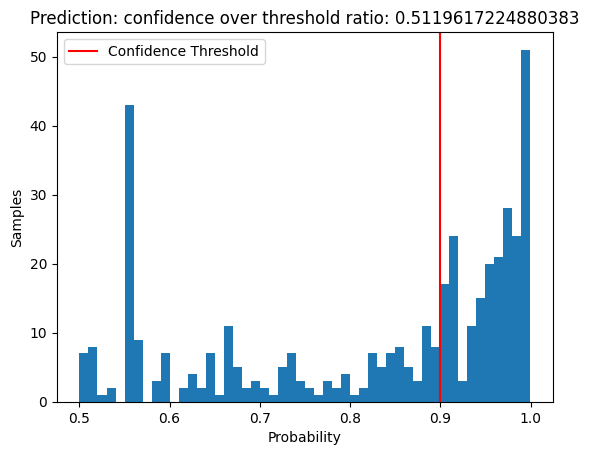

In [36]:
test_predictions = xgb_model.predict(filtered_test)
xgb_prediction_proba = xgb_model.predict_proba(filtered_test)
prediction_threshold_report(xgb_prediction_proba, 0.9)

## Deep Learning Test

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.utils import plot_model

### Specific DL Plotting Functions

In [38]:
def PlotHistory(hist):
    '''
    Function to build the training curve plot
    '''
    
    min_val_loss = np.argmin(hist['val_loss'])
    
    fig, ax = plt.subplots(2, 1, figsize=(16,9))
    
    ax[0].plot(hist['loss'], label = "Training Loss")
    ax[0].plot(hist['val_loss'], label = "Validation Loss")
    ax[0].set_title("Training trend")
    
    ax[1].plot(hist['accuracy'], label = "Training Accuracy")
    ax[1].plot(hist['val_accuracy'], label = "Validation Accuracy")
    ax[1].set_title("Accuracy trend")
    
    for i in range(ax.shape[0]):
        ax[i].axvline(min_val_loss, c="r", label="Restored Here")
        ax[i].legend()
    
    
    plt.show()

In [39]:
x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [40]:
model = Sequential()
model.add(Input(shape=(x_train_tensor.shape[1:])))
model.add(Dense(32, activation=LeakyReLU(negative_slope=0.01), kernel_initializer='random_normal'))
model.add(Dense(128, activation=LeakyReLU(negative_slope=0.01), kernel_initializer='random_normal'))
#model.add(Dropout(0.05))
model.add(Dense(512, activation=LeakyReLU(negative_slope=0.01), kernel_initializer='random_normal'))
model.add(Dense(128, activation=LeakyReLU(negative_slope=0.01), kernel_initializer='random_normal'))
model.add(Dense(64, activation=LeakyReLU(negative_slope=0.01), kernel_initializer='random_normal'))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(learning_rate = 1e-5), loss="binary_crossentropy", metrics=['accuracy'])

model.summary()
# plot_model(model, show_shapes=True) -> ugly to see

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,481 (564.38 KB)

 Trainable params: 144,481 (564.38 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Early Stopping callback to stop training if validation loss does not decrease after 10 epochs
# Alternatively, raise Val Accuracy
es = EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience = 20,
    mode="min",
    restore_best_weights=True
    )

# Max number of epochs and batch size parameters
epochs = 1000

Epoch 1/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5369 - loss: 0.6919 - val_accuracy: 0.6629 - val_loss: 0.6830
Epoch 2/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6118 - loss: 0.6843 - val_accuracy: 0.6629 - val_loss: 0.6753
Epoch 3/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5720 - loss: 0.6853 - val_accuracy: 0.6629 - val_loss: 0.6694
Epoch 4/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6076 - loss: 0.6748 - val_accuracy: 0.6629 - val_loss: 0.6639
Epoch 5/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5677 - loss: 0.6801 - val_accuracy: 0.6629 - val_loss: 0.6601
Epoch 6/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6097 - loss: 0.6713 - val_accuracy: 0.6629 - val_loss: 0.6561
Epoch 7/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5969 - loss: 0.6697 - val_accuracy: 0.6629 - val_loss: 0.6522
Epoch 8/1000
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5669 - loss: 0.6744 - val_accuracy: 0.

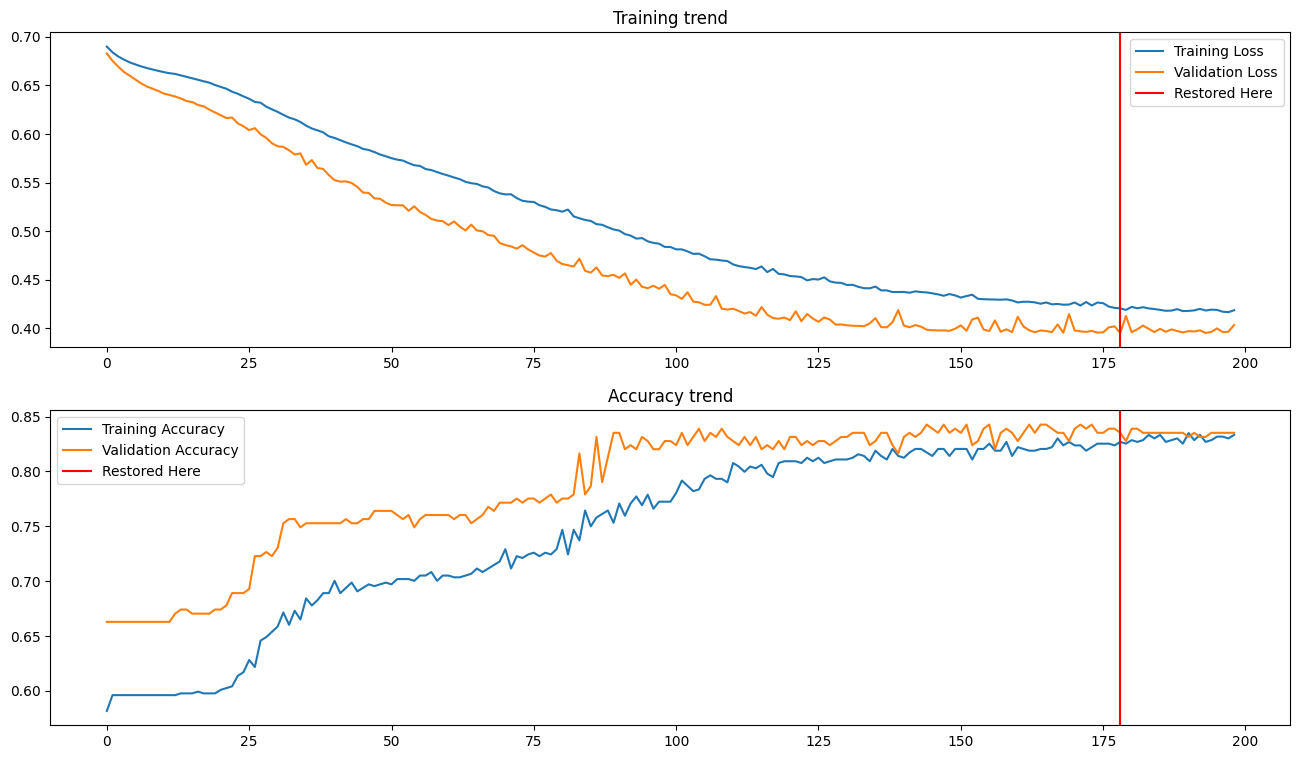

In [42]:
model_filename = "densenet_simple.h5"

if not os.path.isfile(model_filename):
    history = model.fit(x_train_tensor, y_train_tensor, validation_data = (x_test_tensor, y_test_tensor), epochs = epochs, batch_size = 8, callbacks = [es])
    PlotHistory(history.history)
    #model.save(model_filename)
else:
    history = []
    model = load_model(model_filename)

### Validation against Validation Set

It seems less confidend wrt other methods, however predictions were distributed mostly near the "not survived" (second plot)

In [43]:
dl_predictions = model.predict(x_test_tensor)
threshold = 0.5
dl_status_predictions = (dl_predictions >= threshold).astype(int)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [44]:
report = classification_report(y_test.values, dl_status_predictions, output_dict=True)
prettyprint_classification_report(report)

Accuracy obtained: 0.8352059925093633
Macro Average precision: 0.8174225876911216
Macro Average recall: 0.8101694915254237
Macro Average f1 score: 0.8135474860335195


In [45]:
prettyprint_confusion_matrix(confusion_matrix(y_test.values, dl_status_predictions))

True Unsurvived (TN):  157
True  Survived (TP):  66
Predicted Survived but actually Not Alive (FP):  20
Predicted Unsurvived but actually Alive (FN):  24
---Report:---
Computed Precision (True survived over all predicted Survived):  0.7674418604651163
Computed Recall: (True survived over all actual Survived) 0.7333333333333333
Computed True Negative Rate: (True Unsurvived over all actual Unsurvived) 0.8870056497175142
Computed Balanced Accuracy:  0.8101694915254237
Computed F1 Score:  0.7499999999999999


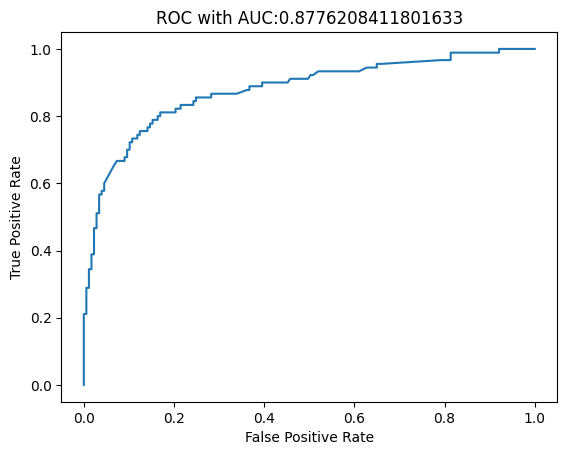

In [46]:
plot_roc_curve(y_test.values, dl_predictions)

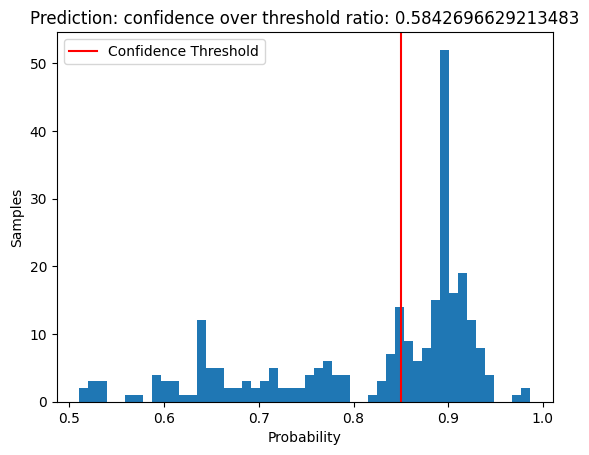

In [47]:
prediction_threshold_report(np.c_[dl_predictions, 1-dl_predictions], 0.85)


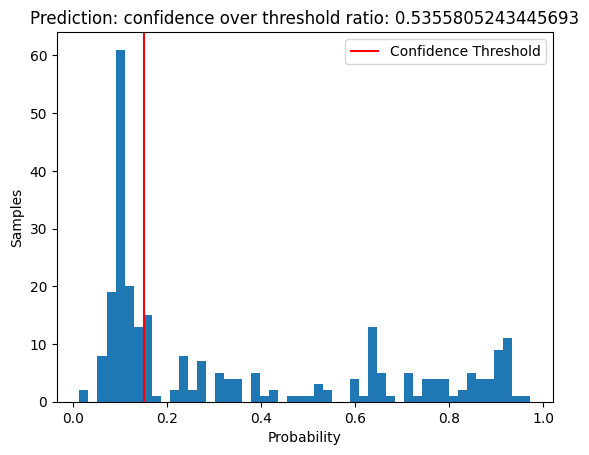

In [48]:
prediction_threshold_report(np.c_[dl_predictions, dl_predictions], 0.15)

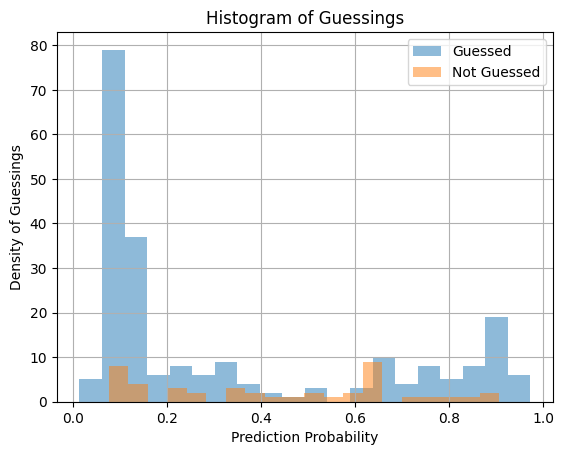

In [49]:
plot_probability_guessing_hists(y_test.values, dl_status_predictions[:,0], dl_predictions)

### Explainable AI with Lime

In [50]:
def assign_status_from_proba(prob, threshold=0.5):
    print(prob)
    return 1 if prob > threshold else 0


assign_status = lambda x: assign_status_from_proba(model.predict(x))

In [51]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.asarray(x_train), feature_names=x_train.columns, class_names=[0, 1],  discretize_continuous=True)

In [52]:
%%capture
i = np.random.randint(0, x_test.shape[0])
exp = explainer.explain_instance(x_test.values[i], model.predict, num_features=5, top_labels=1)

In [53]:
print(model.predict(x_test_tensor)[i], y_test.iloc[i])
exp.show_in_notebook(show_table=True, show_all=True)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.15040822] 0


In [54]:
%%capture
sp_obj = SubmodularPick(explainer, x_train.values, model.predict, sample_size=50, num_features=len(x_train.columns), num_exps_desired=1)

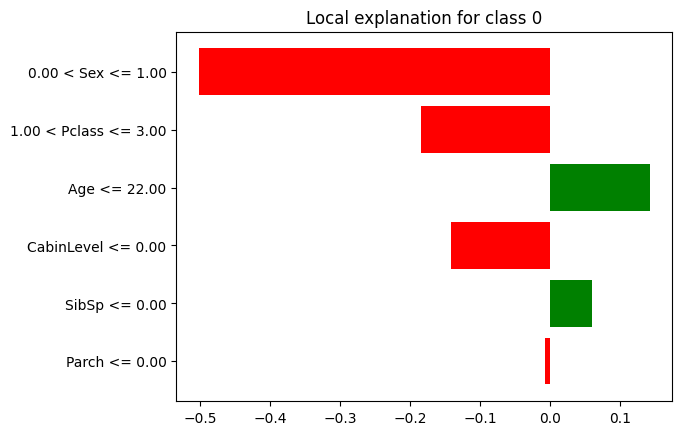

In [55]:
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

### On Kaggle Test Set

In [56]:
filtered_test_tensor = tf.convert_to_tensor(filtered_test, dtype=tf.float32)
predictions = model.predict(filtered_test_tensor)
threshold = 0.5
predictions = (predictions >= threshold).astype(int)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [57]:
results = pd.DataFrame(data = predictions, index=filtered_test.index, columns=["Survived"])
results


,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [58]:
results.to_csv("submission_DeepLearning_more_accuracy.csv")